In [3]:
# %% Cell 1: Import Necessary Libraries and Set Random Seeds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

import shap

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device (use GPU if available)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using mps device


/Users/steveschmidt/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
# %% Cell 2: Read the Spotify Tracks Dataset from 'dataset.csv'
# https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset
df = pd.read_csv('dataset.csv')
print("Dataset shape:", df.shape)
print("First few rows:")
print(df.head())

Dataset shape: (114000, 21)
First few rows:
   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin 

In [6]:
df.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

In [61]:
# %% Cell 3: Preprocess Data and Prepare Features, Target, and Metadata
# Define the numerical features for the embedding (9 features)
num_features = ['danceability', 'energy', 'loudness', 'speechiness', 
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Use 'track_genre' as the target label for classification.
target_column = 'track_genre'

# Define a function to bucket the popularity into ranges (e.g., "0-10", "10-20", …, "90-100").
def bucket_popularity(pop):
    bucket = int(pop) // 10 * 10
    return f"{bucket}-{bucket+10}"

# Create a metadata column with tab-separated fields: Genre, Bucketed Popularity, Artist, and Album.
# For example: "Pop    40-50    The Beatles    Abbey Road"
df['meta'] = df.apply(lambda row: f"{row['track_genre']}\t{bucket_popularity(row['popularity'])}\t{row['artists']}\t{row['album_name']}", axis=1)

# Drop rows with missing values in the columns we care about.
df = df.dropna(subset=num_features + [target_column, 'meta'])

# Extract the features, target, and metadata.
X = df[num_features].values
y = df[target_column].values
meta_info = df['meta'].values  # Each entry is a tab-separated string

# Encode the target genres as integers.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into training and testing sets.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X, y_encoded, meta_info, test_size=0.2, random_state=42)

# Standardize the numerical features.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Train set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)


Train set shape: (91200, 9)
Test set shape: (22800, 9)


In [62]:
# %% Cell 4: Create a Custom PyTorch Dataset
class SpotifyDataset(Dataset):
    def __init__(self, X, y, meta):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.meta = meta  # list or array of metadata strings
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.meta[idx]

train_dataset = SpotifyDataset(X_train_scaled, y_train, meta_train)
test_dataset  = SpotifyDataset(X_test_scaled, y_test, meta_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Number of training samples:", len(train_dataset))


Number of training samples: 91200


In [63]:
# %% Cell 5: Define the Feed-Forward Network for Song Embeddings
class SpotifyEmbeddingNet(nn.Module):
    def __init__(self, input_dim=9, embedding_dim=16, num_classes=len(le.classes_)):
        super(SpotifyEmbeddingNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        # Embedding layer: the penultimate layer whose activations we want to inspect
        self.embedding = nn.Linear(32, embedding_dim)
        # Final classification layer
        self.classifier = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        emb = torch.relu(self.embedding(x))
        out = self.classifier(emb)
        return out, emb

model = SpotifyEmbeddingNet().to(device)
print(model)


SpotifyEmbeddingNet(
  (fc1): Linear(in_features=9, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (embedding): Linear(in_features=32, out_features=16, bias=True)
  (classifier): Linear(in_features=16, out_features=114, bias=True)
)


In [64]:
# %% Cell 6: Train the Model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for X_batch, y_batch, _ in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs, _ = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Training complete.")


Epoch 1/20, Loss: 3.8679
Epoch 2/20, Loss: 3.6286
Epoch 3/20, Loss: 3.5763
Epoch 4/20, Loss: 3.5408
Epoch 5/20, Loss: 3.5155
Epoch 6/20, Loss: 3.4950
Epoch 7/20, Loss: 3.4793
Epoch 8/20, Loss: 3.4659
Epoch 9/20, Loss: 3.4538
Epoch 10/20, Loss: 3.4452
Epoch 11/20, Loss: 3.4370
Epoch 12/20, Loss: 3.4294
Epoch 13/20, Loss: 3.4232
Epoch 14/20, Loss: 3.4172
Epoch 15/20, Loss: 3.4118
Epoch 16/20, Loss: 3.4073
Epoch 17/20, Loss: 3.4030
Epoch 18/20, Loss: 3.3997
Epoch 19/20, Loss: 3.3963
Epoch 20/20, Loss: 3.3934
Training complete.


In [103]:
# %% Cell 7: Extract Embeddings and Log to TensorBoard with Metadata: Genre, Artist, Album

import shutil
# Clear previous logs:
shutil.rmtree("runs/spotify_embeddings", ignore_errors=True)

model.eval()
all_embeddings = []
all_labels = []
all_meta = []  # Will store metadata as a list-of-lists: [Genre, Artist, Album]

# Process the test set using the DataLoader defined earlier.
with torch.no_grad():
    for X_batch, y_batch, meta_batch in test_loader:
        X_batch = X_batch.to(device)
        _, emb = model(X_batch)
        all_embeddings.append(emb.cpu())
        all_labels.append(y_batch)
        # Each entry in meta_batch is originally a string like:
        # "Genre\tBucketedPopularity\tArtist\tAlbum"
        # We extract Genre (first field), Artist (third field), and Album (fourth field).
        for meta in meta_batch:
            fields = meta.split("\t")
            genre = fields[0] if len(fields) >= 1 else "Unknown"
            artist = fields[2] if len(fields) >= 3 else "Unknown"
            album = fields[3] if len(fields) >= 4 else "Unknown"
            all_meta.append([genre, artist, album])

embeddings_tensor = torch.cat(all_embeddings, dim=0)
labels_tensor = torch.cat(all_labels, dim=0)

# Ensure that the number of metadata rows equals the number of embeddings.
num_embeddings = embeddings_tensor.shape[0]
if len(all_meta) < num_embeddings:
    diff = num_embeddings - len(all_meta)
    print(f"Metadata is missing {diff} entries. Appending dummy rows.")
    all_meta.extend([["Unknown", "Unknown", "Unknown"]] * diff)
elif len(all_meta) > num_embeddings:
    diff = len(all_meta) - num_embeddings
    print(f"Metadata has {diff} extra entries. Truncating the list.")
    all_meta = all_meta[:num_embeddings]

# Create a header for multi-column metadata.
header = ["Genre", "Artist", "Album"]

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/spotify_embeddings")
writer.add_embedding(embeddings_tensor, metadata=all_meta, metadata_header=header, tag="SpotifyEmbeddings")
writer.close()

print("Embeddings logged to TensorBoard in 'runs/spotify_embeddings'.")
print("Launch TensorBoard with: tensorboard --logdir=runs/spotify_embeddings")


Embeddings logged to TensorBoard in 'runs/spotify_embeddings'.
Launch TensorBoard with: tensorboard --logdir=runs/spotify_embeddings


In [66]:
# %% Cell 8: Retrieve Top-K Similar Songs Using Cosine Similarity
def get_top_k_similar(embeddings, song_idx, top_k=5):
    # Convert embeddings to numpy
    emb_np = embeddings.numpy()
    # Compute cosine similarity between all pairs
    sim_matrix = cosine_similarity(emb_np)
    # Get similarity scores for the chosen song (excluding itself)
    scores = sim_matrix[song_idx]
    similar_indices = np.argsort(-scores)
    similar_indices = similar_indices[similar_indices != song_idx]  # Exclude the song itself
    return similar_indices[:top_k], scores[similar_indices[:top_k]]

# For demonstration, choose a sample song from the test set embeddings.
sample_idx = 10
top_k_indices, top_k_scores = get_top_k_similar(embeddings_tensor, sample_idx, top_k=5)
print(f"Top 5 songs similar to song index {sample_idx}:")
for idx, score in zip(top_k_indices, top_k_scores):
    print(f"Song index {idx}, Similarity: {score:.4f}")


Top 5 songs similar to song index 10:
Song index 3898, Similarity: 1.0000
Song index 17087, Similarity: 1.0000
Song index 2281, Similarity: 1.0000
Song index 16750, Similarity: 1.0000
Song index 1008, Similarity: 0.9845


In [117]:
df.index

RangeIndex(start=0, stop=114000, step=1)

In [46]:
# %% Cell 9: Apply SHAP to Inspect Feature Importance Using the New SHAP v0.20+ API for Multi-Output Models

# Ensure the wrapper model is in evaluation mode.
model_wrapper.eval()

# Create a background sample from the training data.
background = torch.tensor(
    X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)],
    dtype=torch.float32
).to(device)

# Choose one test sample to explain.
sample_to_explain = torch.tensor(X_test_scaled[0:1], dtype=torch.float32).to(device)

# Try using DeepExplainer; if it fails, fall back to GradientExplainer.
try:
    explainer = shap.DeepExplainer(model_wrapper, background)
    shap_values = explainer.shap_values(sample_to_explain)
    expected_value = explainer.expected_value
except AssertionError as e:
    print("DeepExplainer encountered an error:", e)
    print("Falling back to GradientExplainer.")
    explainer = shap.GradientExplainer(model_wrapper, background)
    shap_values = explainer.shap_values(sample_to_explain)
    # Compute the expected value as the mean model output on the background.
    bg_preds = model_wrapper(background).cpu().detach().numpy()
    expected_value = np.mean(bg_preds, axis=0)

# If shap_values is a list, convert it to a NumPy array.
if isinstance(shap_values, list):
    shap_values = np.array(shap_values)

# For multi-output models, SHAP now recommends using:
# shap.plots.force(explainer.expected_value[0], shap_values[..., 0], feature_names=num_features)
# Here, we assume expected_value is an array (or list) of shape (num_classes,) and
# shap_values has an extra axis for outputs, e.g. shape (batch, num_features, num_classes).
# We then index the first element of the expected value and the first output column.
shap.initjs()
shap.plots.force(expected_value[0], shap_values[..., 0], feature_names=num_features)


DeepExplainer encountered an error: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 4.417855128645897 - Tolerance: 0.01
Falling back to GradientExplainer.


# Force Plot Explanation

The **force plot** is an interactive visualization that explains the output of the model for a single sample by showing the contribution (SHAP value) of each feature:

- **Base Value (Expected Value):**  
  This is the average model output over the background dataset. It represents the starting point before any feature contributions are applied.

- **Feature Contributions:**  
  - **Red segments** indicate features that **push the prediction higher** (i.e., they add to the base value).  
  - **Blue segments** indicate features that **push the prediction lower** (i.e., they subtract from the base value).

- **Visualization Details:**  
  - The features are shown as bars along a horizontal axis.  
  - The width (or length) of each colored bar represents the magnitude of that feature's SHAP value (i.e., how much it shifts the prediction).  
  - The final model output is the sum of the base value and all the individual feature contributions.
  
Overall, the force plot provides an intuitive look at which features are driving the model's decision for a specific sample.


DeepExplainer encountered an error on subset: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 10.951691791415215 - Tolerance: 0.01
Falling back to GradientExplainer for subset.


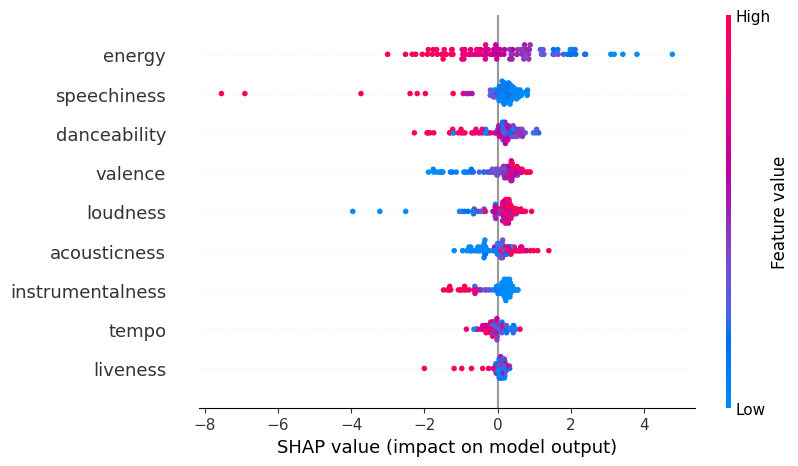

In [67]:
# %% Cell: Create a SHAP Beeswarm Plot for a Subset of Test Samples with Color Gradient

# Use a subset (e.g., the first 50 samples) from the test set for the beeswarm plot.
subset_size = 100
X_subset = torch.tensor(X_test_scaled[:subset_size], dtype=torch.float32).to(device)

# Compute SHAP values for the subset.
try:
    explainer_subset = shap.DeepExplainer(model_wrapper, background)
    shap_values_subset = explainer_subset.shap_values(X_subset)
    expected_value_subset = explainer_subset.expected_value
except AssertionError as e:
    print("DeepExplainer encountered an error on subset:", e)
    print("Falling back to GradientExplainer for subset.")
    explainer_subset = shap.GradientExplainer(model_wrapper, background)
    shap_values_subset = explainer_subset.shap_values(X_subset)
    bg_preds_subset = model_wrapper(background).cpu().detach().numpy()
    expected_value_subset = np.mean(bg_preds_subset, axis=0)

# If shap_values_subset is returned as a list (common for multi-output models),
# extract the explanation for the first output (or the only output if length is 1).
if isinstance(shap_values_subset, list):
    if len(shap_values_subset) == 1:
        shap_values_array = shap_values_subset[0]
    else:
        shap_values_array = shap_values_subset[0]
else:
    shap_values_array = shap_values_subset

# If the resulting array has more than 2 dimensions, select the first slice along the output dimension.
if len(shap_values_array.shape) > 2:
    shap_values_beeswarm = shap_values_array[..., 0]
else:
    shap_values_beeswarm = shap_values_array

# IMPORTANT: Create a SHAP Explanation object that includes the original feature data.
# Passing the data allows the beeswarm plot to color the points based on feature values.
explanation = shap.Explanation(
    values=shap_values_beeswarm, 
    data=X_subset.cpu().numpy(), 
    feature_names=num_features
)

# Plot the beeswarm plot without forcing a constant color.
shap.initjs()
shap.plots.beeswarm(explanation)


## Beeswarm Plot Explanation

The **beeswarm plot** provides a global view of feature impacts over a subset of samples. It visualizes the distribution of SHAP values for each feature:

- **Dots Represent Individual Samples:**  
  Each dot corresponds to one sample’s SHAP value for that feature.

- **Color Encoding:**  
  - The color of each dot reflects the actual value of the feature for that sample.  
  - A typical color gradient (e.g., blue for low values to red for high values) helps indicate whether higher or lower feature values tend to increase or decrease the prediction.

- **X-axis (SHAP Value):**  
  The horizontal position of a dot shows how much that feature value pushed the model output higher (positive SHAP value) or lower (negative SHAP value).

- **Feature Importance Ranking:**  
  Features are typically ordered vertically by their overall impact (the average magnitude of their SHAP values).  
  A wider spread of SHAP values indicates that the feature has a variable and often strong influence on the model's predictions.

This plot helps identify:
- Which features have the strongest and most consistent impact.
- The direction of the effect of high or low feature values.
- Variability in feature contributions across different samples.


In [110]:
df.sort_values(by='popularity', ascending=False)[['track_name', 'popularity']][:50]

,track_name,popularity
20001,Unholy (feat. Kim Petras),100
81051,Unholy (feat. Kim Petras),100
51664,"Quevedo: Bzrp Music Sessions, Vol. 52",99
81210,I'm Good (Blue),98
89411,La Bachata,98
68303,La Bachata,98
88410,La Bachata,98
30003,I'm Good (Blue),98
20008,I'm Good (Blue),98
67356,La Bachata,98


In [38]:
# %% Cell: Print Embedding Vector and Cosine Similarity for 'Jump'

# First, find the song(s) with track_name equal to 'Jump'
jump_df = df[df['track_name'] == "As It Was"]
if jump_df.empty:
    print("Song not found in the dataset!")
else:
    # For demonstration, take the first occurrence
    jump_index = jump_df.index[0]
    print(f"Found SONG INPUT at DataFrame index: {jump_index}")
    
    # Compute embeddings for the entire dataset.
    # Extract the numerical features for all songs.
    X_all = scaler.transform(df[num_features].values)
    X_all_tensor = torch.tensor(X_all, dtype=torch.float32).to(device)
    
    # Get embeddings from the model (make sure model is in eval mode)
    model.eval()
    with torch.no_grad():
        _, all_emb = model(X_all_tensor)
    # Convert embeddings to a NumPy array
    all_embeddings = all_emb.cpu().numpy()
    
    # Get the embedding vector for 'Jump'
    jump_vector = all_embeddings[jump_index]
    print("\nEmbedding vector for SONG INPUT:")
    print(jump_vector)
    
    # Compute cosine similarities between the 'Jump' embedding and all other embeddings
    sim_scores = cosine_similarity([jump_vector], all_embeddings)[0]
    
    # Sort indices by descending similarity, excluding the song itself
    sorted_indices = np.argsort(-sim_scores)
    sorted_indices = sorted_indices[sorted_indices != jump_index]
    
    # Retrieve the top 3 similar songs
    top3_indices = sorted_indices[:5]
    
    print("\nTop 3 similar songs to SONG INPUT:")
    for idx in top3_indices:
        song_title = df.iloc[idx]['track_name']
        score = sim_scores[idx]
        vector = all_embeddings[idx]
        print(f"\nSong: {song_title}")
        print(f"Cosine Similarity: {score:.4f}")
        print("Embedding vector:")
        print(vector)


Found SONG INPUT at DataFrame index: 161

Embedding vector for SONG INPUT:
[4.4278197 0.4016487 1.3399937 0.        3.1412547 2.7303216 0.
 0.333205  0.        0.        3.0920417 0.        3.608374  0.5460104
 1.7928271 0.       ]

Top 3 similar songs to SONG INPUT:

Song: Feels Like Home
Cosine Similarity: 0.9969
Embedding vector:
[5.1086826  0.29983318 1.7471302  0.         3.657628   2.859384
 0.         0.03312144 0.         0.         3.1277068  0.
 3.7134194  0.7064924  1.9181411  0.081278  ]

Song: Feels Like Home
Cosine Similarity: 0.9969
Embedding vector:
[5.1086826  0.29983318 1.7471302  0.         3.657628   2.859384
 0.         0.03312144 0.         0.         3.1277068  0.
 3.7134194  0.7064924  1.9181411  0.081278  ]

Song: Iniyennum Ee Lokham
Cosine Similarity: 0.9967
Embedding vector:
[4.5344753  0.66530836 1.1574284  0.         3.140161   2.6158752
 0.         0.5419646  0.         0.         3.3710465  0.
 3.6082976  0.9279888  1.9889598  0.2304006 ]

Song: Feels Lik

In [120]:
no_dups_df = df.sort_values(by='popularity', ascending=False)[['track_name', 'popularity']].drop_duplicates(subset=['track_name'])

In [121]:
no_dups_df.sort_values(by='popularity', ascending=False)[['track_name', 'popularity']][:25]

,track_name,popularity
20001,Unholy (feat. Kim Petras),100
51664,"Quevedo: Bzrp Music Sessions, Vol. 52",99
81210,I'm Good (Blue),98
89411,La Bachata,98
68305,Me Porto Bonito,97
68304,Tití Me Preguntó,97
68359,Efecto,96
81174,I Ain't Worried,96
81003,Under The Influence,96
67500,Ojitos Lindos,95


In [122]:
# %% Cell: Print Embedding Vector and Cosine Similarity for 'Jump'

# First, find the song(s) with track_name equal to 'Jump'
jump_df = no_dups_df[no_dups_df['track_name'] == "Me Porto Bonito"]
if jump_df.empty:
    print("Song not found in the dataset!")
else:
    # For demonstration, take the first occurrence
    jump_index = jump_df.index[0]
    print(f"Found SONG INPUT at DataFrame index: {jump_index}")
    
    # Compute embeddings for the entire dataset.
    # Extract the numerical features for all songs.
    X_all = scaler.transform(df[num_features].values)
    X_all_tensor = torch.tensor(X_all, dtype=torch.float32).to(device)
    
    # Get embeddings from the model (make sure model is in eval mode)
    model.eval()
    with torch.no_grad():
        _, all_emb = model(X_all_tensor)
    # Convert embeddings to a NumPy array
    all_embeddings = all_emb.cpu().numpy()
    
    # Get the embedding vector for 'Jump'
    jump_vector = all_embeddings[jump_index]
    print("\nEmbedding vector for SONG INPUT:")
    print(jump_vector)
    
    # Compute cosine similarities between the 'Jump' embedding and all other embeddings
    sim_scores = cosine_similarity([jump_vector], all_embeddings)[0]
    
    # Sort indices by descending similarity, excluding the song itself
    sorted_indices = np.argsort(-sim_scores)
    sorted_indices = sorted_indices[sorted_indices != jump_index]
    
    # Retrieve the top 3 similar songs
    top3_indices = sorted_indices[:5]
    
    print("\nTop similar songs to SONG INPUT:")
    for idx in top3_indices:
        song_title = df.iloc[idx]['track_name']
        score = sim_scores[idx]
        vector = all_embeddings[idx]
        print(f"\nSong: {song_title}")
        print(f"Cosine Similarity: {score:.4f}")
        print("Embedding vector:")
        print(vector)


Found SONG INPUT at DataFrame index: 68305

Embedding vector for SONG INPUT:
[0.         3.0315015  2.6678538  0.32818896 0.5575057  3.425713
 1.3518136  0.69100636 0.6275295  8.309257   5.3163476  0.
 1.5835497  3.650635   0.         0.        ]

Top similar songs to SONG INPUT:

Song: Me Porto Bonito
Cosine Similarity: 1.0000
Embedding vector:
[0.         3.0315015  2.6678538  0.32818896 0.5575057  3.425713
 1.3518136  0.69100636 0.6275295  8.309257   5.3163476  0.
 1.5835497  3.650635   0.         0.        ]

Song: Me Porto Bonito
Cosine Similarity: 1.0000
Embedding vector:
[0.         3.0315015  2.6678538  0.32818896 0.5575057  3.425713
 1.3518136  0.69100636 0.6275295  8.309257   5.3163476  0.
 1.5835497  3.650635   0.         0.        ]

Song: Me Porto Bonito
Cosine Similarity: 1.0000
Embedding vector:
[0.         3.0315015  2.6678538  0.32818896 0.5575057  3.425713
 1.3518136  0.69100636 0.6275295  8.309257   5.3163476  0.
 1.5835497  3.650635   0.         0.        ]

Song: B